# Plot search metrics and other dynamical measures as a function of one or more filament parameters
Examples
- Unique location sampling rate vs parameter
- Filament behavior (periodic, aperiodic etc.) vs parameter
- ...

In [3]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

from tqdm import tqdm


# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure2'

import _figure_parameters


linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [38]:
# Specify folder which to analyze

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep_RandomAnglesIC']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2022-03-05']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityTimeSweep_constantActivity_1.5']

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivitySims_2022_11_11']

In [39]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames and 'ic' not in fileNames):
                files_list.append(os.path.join(dirs,fileNames))


print('No:of files: {}'.format(len(files_list)))

# Collect all data into a single data frame
df = pd.DataFrame({})

for file in files_list:
    
    df = df.append(pd.read_csv(file))
    
print(np.unique(df['period']))

period_values = np.array([value for value in np.unique(df['period']) if not np.isnan(value)])

period_values = np.sort(period_values)
print(period_values)

# Assign some categorical variables to the data
df['periodic dynamics'][df['periodic dynamics']==1] = True
df['periodic dynamics'][df['periodic dynamics']==0] = False
df['period'][pd.isna(df['period'])] = 'aperiodic'
df['period'][df['simulation completed']== False] = 'Escape'
df

No:of files: 93
[ 1.  2.  6. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[1. 2. 6.]


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,N particles,radius,bond length,spring constant,kappa_hat,force strength,stresslet strength,potDipole strength,simulation type,...,viscosity,period,threshold index,simulation completed,periodic dynamics,max unique locations,activity cycles completed,search efficiency,activity number,filament behavior
0,0,32,1,2.1,25,6.25,0,0,0.267857,dist,...,0.166667,aperiodic,0,True,False,427.0,500,0.008851,14.4150,aperiodic
0,0,32,1,2.1,25,6.25,0,0,0.267857,dist,...,0.166667,aperiodic,0,True,False,417.0,500,0.008640,14.4150,aperiodic
0,0,32,1,2.1,25,6.25,0,0,0.267857,dist,...,0.166667,aperiodic,0,True,False,431.0,500,0.008934,14.4150,aperiodic
0,0,32,1,2.1,25,6.25,0,0,0.385714,dist,...,0.166667,2,9,True,True,254.0,500,0.003166,20.7576,2n-period
0,0,32,1,2.1,25,6.25,0,0,0.385714,dist,...,0.166667,2,8,True,True,226.0,500,0.002816,20.7576,2n-period
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,32,1,2.1,25,6.25,0,0,0.150000,dist,...,0.166667,1,83,True,True,248.0,500,0.008081,8.0724,1-period
0,0,32,1,2.1,25,6.25,0,0,0.150000,dist,...,0.166667,1,1,True,True,250.0,500,0.008156,8.0724,1-period
0,0,32,1,2.1,25,6.25,0,0,0.228571,dist,...,0.166667,aperiodic,0,True,False,511.0,500,0.011652,12.3008,aperiodic
0,0,32,1,2.1,25,6.25,0,0,0.228571,dist,...,0.166667,aperiodic,0,True,False,511.0,500,0.011649,12.3008,aperiodic


In [40]:
parameter = 'potDipole strength'
# parameter = ' activity time scale'

## 1. Filament behavior vs Parameter of Interest

<IPython.core.display.Javascript object>


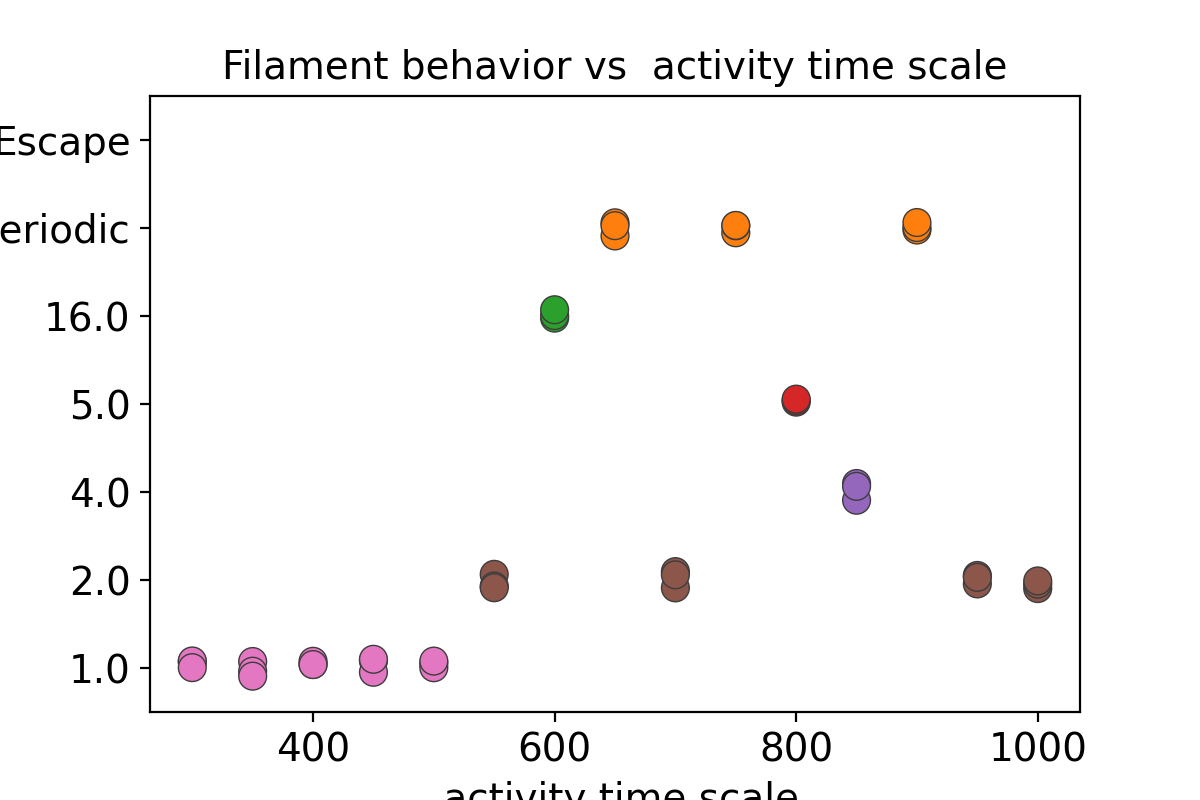

In [9]:
# Categorical Plot of Filament behavior vs Parameter value
save = False

title = 'Filament behavior vs {}'.format(parameter)
plt.figure(figsize=(6,4))
sns.stripplot(data = df, x = parameter, y = 'period', order = ['Escape', 'aperiodic'] + list(period_values), size = 10, linewidth = 0.5)
plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


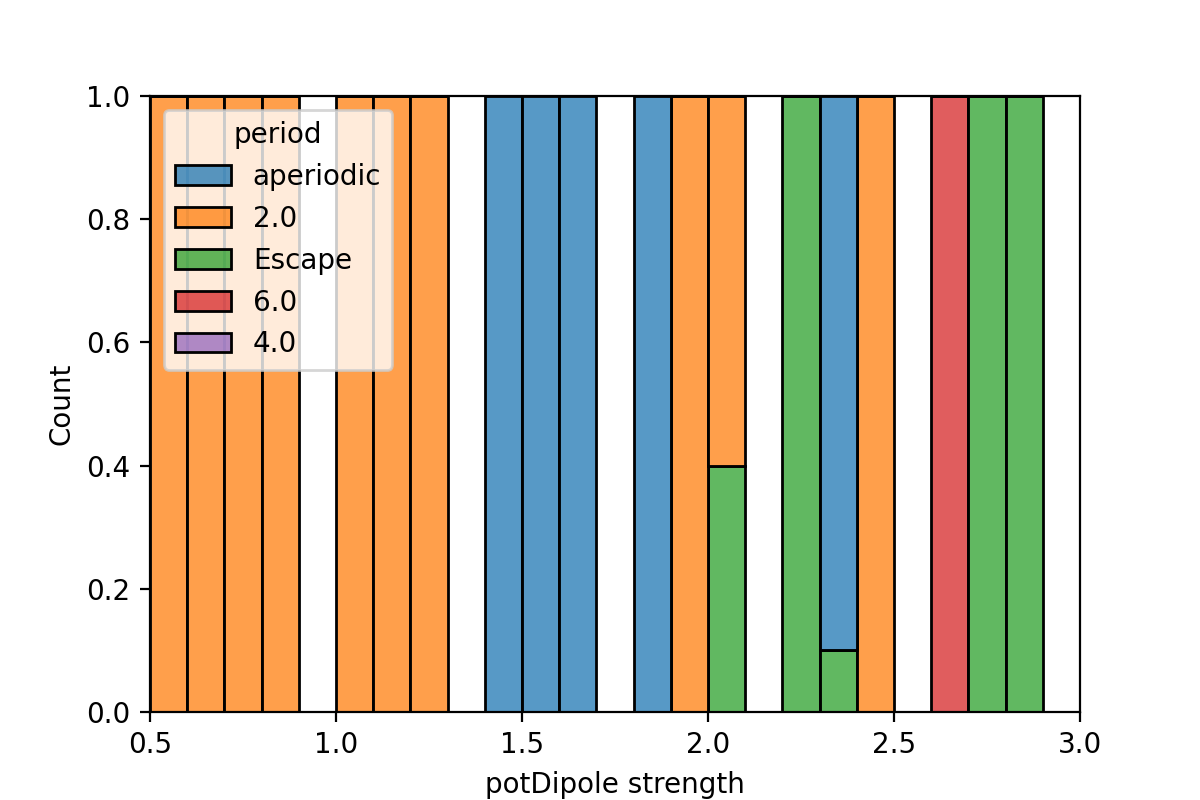

In [33]:
# Plot percent of IC leading to a certain behavior

parameter = 'potDipole strength'
save = True

title = 'Observation of filament behavior vs {}'.format(parameter)
plt.figure(figsize=(6,4))

sns.histplot(data = df, x = parameter, hue = 'period', multiple = 'fill', binwidth = 0.1)
plt.show()



## 2. Plot Max unique locations sampled vs Activity strength

<IPython.core.display.Javascript object>


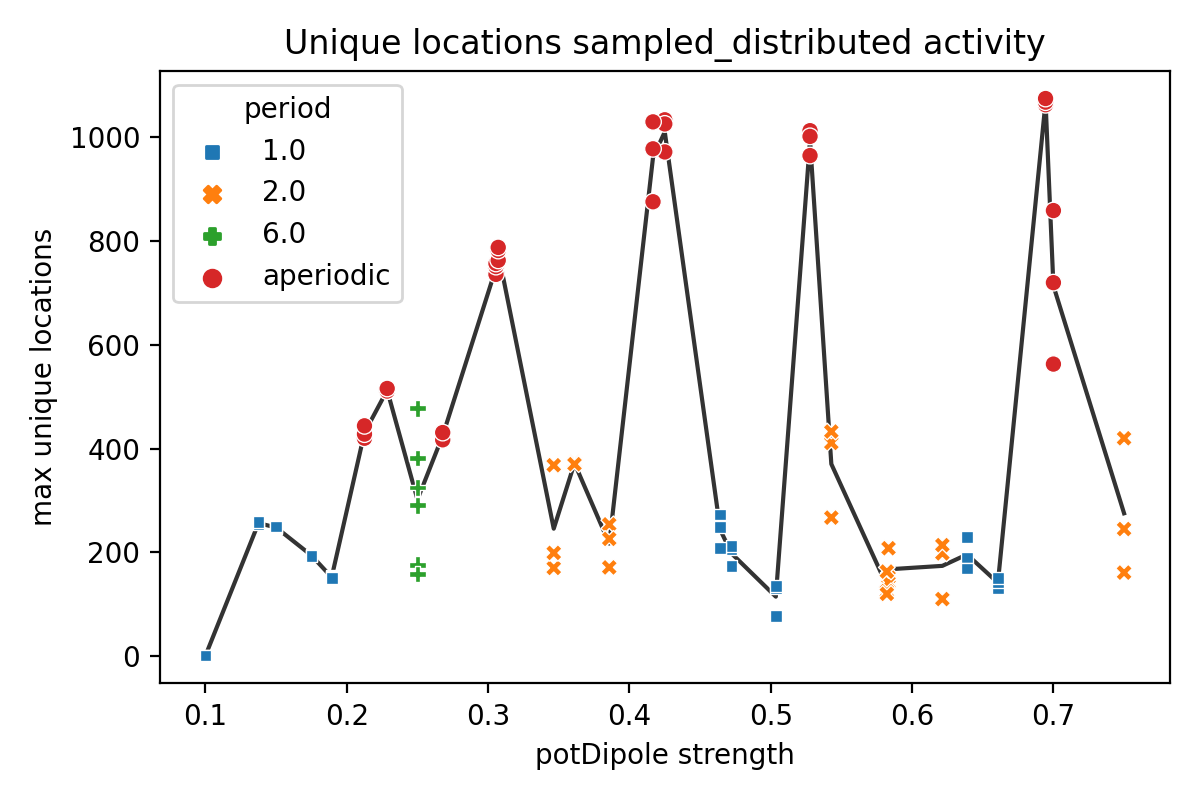

In [45]:
parameter = 'potDipole strength'
save = True

# Take subset of data for which simulation was completed
df_subset = df.loc[df['simulation completed']==True]

# df_subset = df_subset.loc[df_subset[parameter]<=3.0]


# df_subset['unique location sampling rate'] = df_subset['max unique locations']/df_subset['activity cycles completed']

note = ''
title = 'Unique locations sampled'+'_distributed activity'
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

# ax1 = sns.lineplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=95, err_style = 'bar', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)
ax1 = sns.lineplot(data=df_subset, x= parameter, y= 'max unique locations', style=" activity time scale", markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False, zorder =0)

ax2 = sns.scatterplot(data=df_subset, x= parameter, y= 'max unique locations', style="period", hue = 'period', hue_order = list(period_values) +['aperiodic'], zorder=10)


# ax.set_xscale('log')
plt.title(title)
plt.tight_layout()

if (save):
    plt.savefig(os.path.join(publication_figures, title+note + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+note + '.svg'), dpi = 300)
plt.show()

## Compare full simulations with Predicted Dynamics
- Compare full simulations with predictions for single-cycle dynamics (single compression-extensional)

<IPython.core.display.Javascript object>


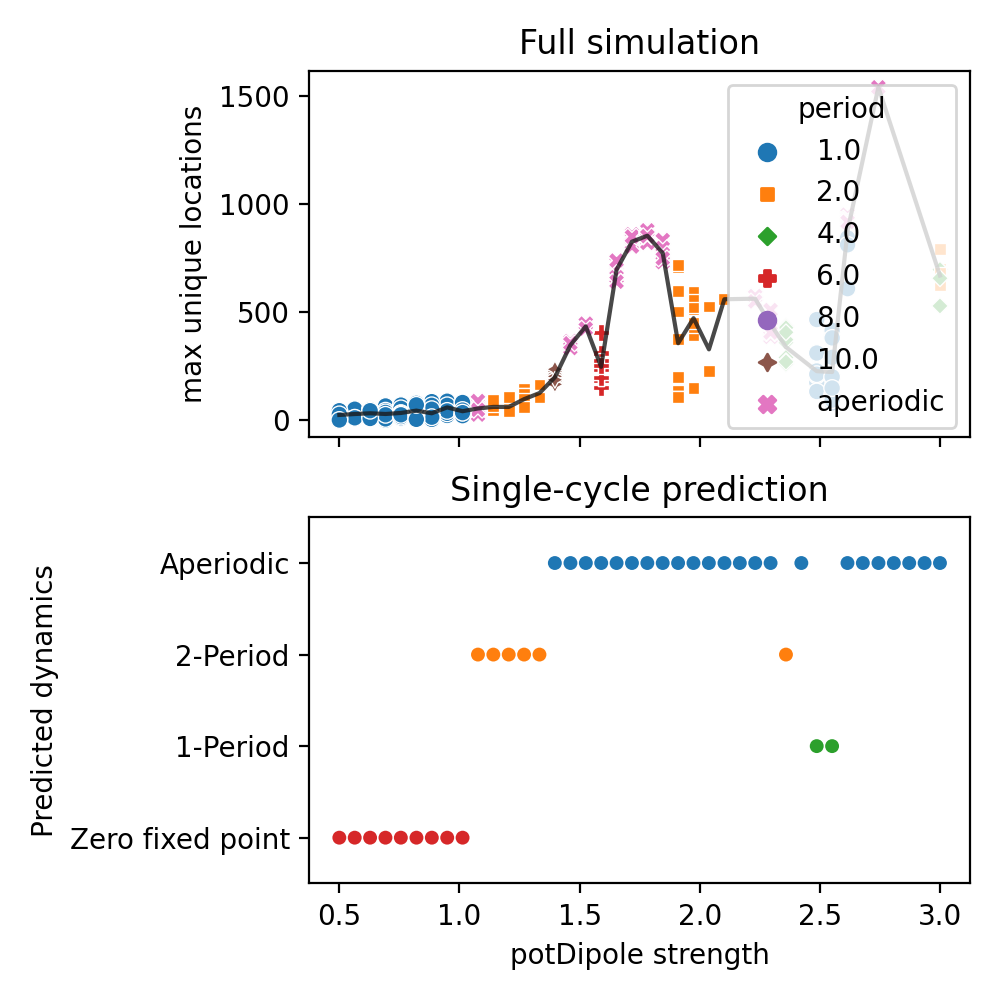

In [83]:
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure4'

save = True 

predicted_dynamics = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL/PredictedDynamics/PredictedDynamics.csv'

df_predicted_dynamics = pd.read_csv(predicted_dynamics)

fig,(ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (5,5))
title = 'FullSimVsPredictedDynamics'
sns.lineplot(data=df_subset, x= parameter, y= 'max unique locations', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0)

sns.scatterplot(data=df_subset, x= parameter, y=  'max unique locations', style="period", 
                hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'], ax = ax0)

sns.stripplot(data = df_predicted_dynamics, x = parameter, y = 'Predicted dynamics', 
            order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], ax = ax1, jitter = False)

ax0.title.set_text('Full simulation')
ax1.title.set_text('Single-cycle prediction')

# plt.title(title)

plt.tight_layout()

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()





### Compare Full-simulations, Predicted Dynamics and Calculated Lyapunov exponents

<IPython.core.display.Javascript object>


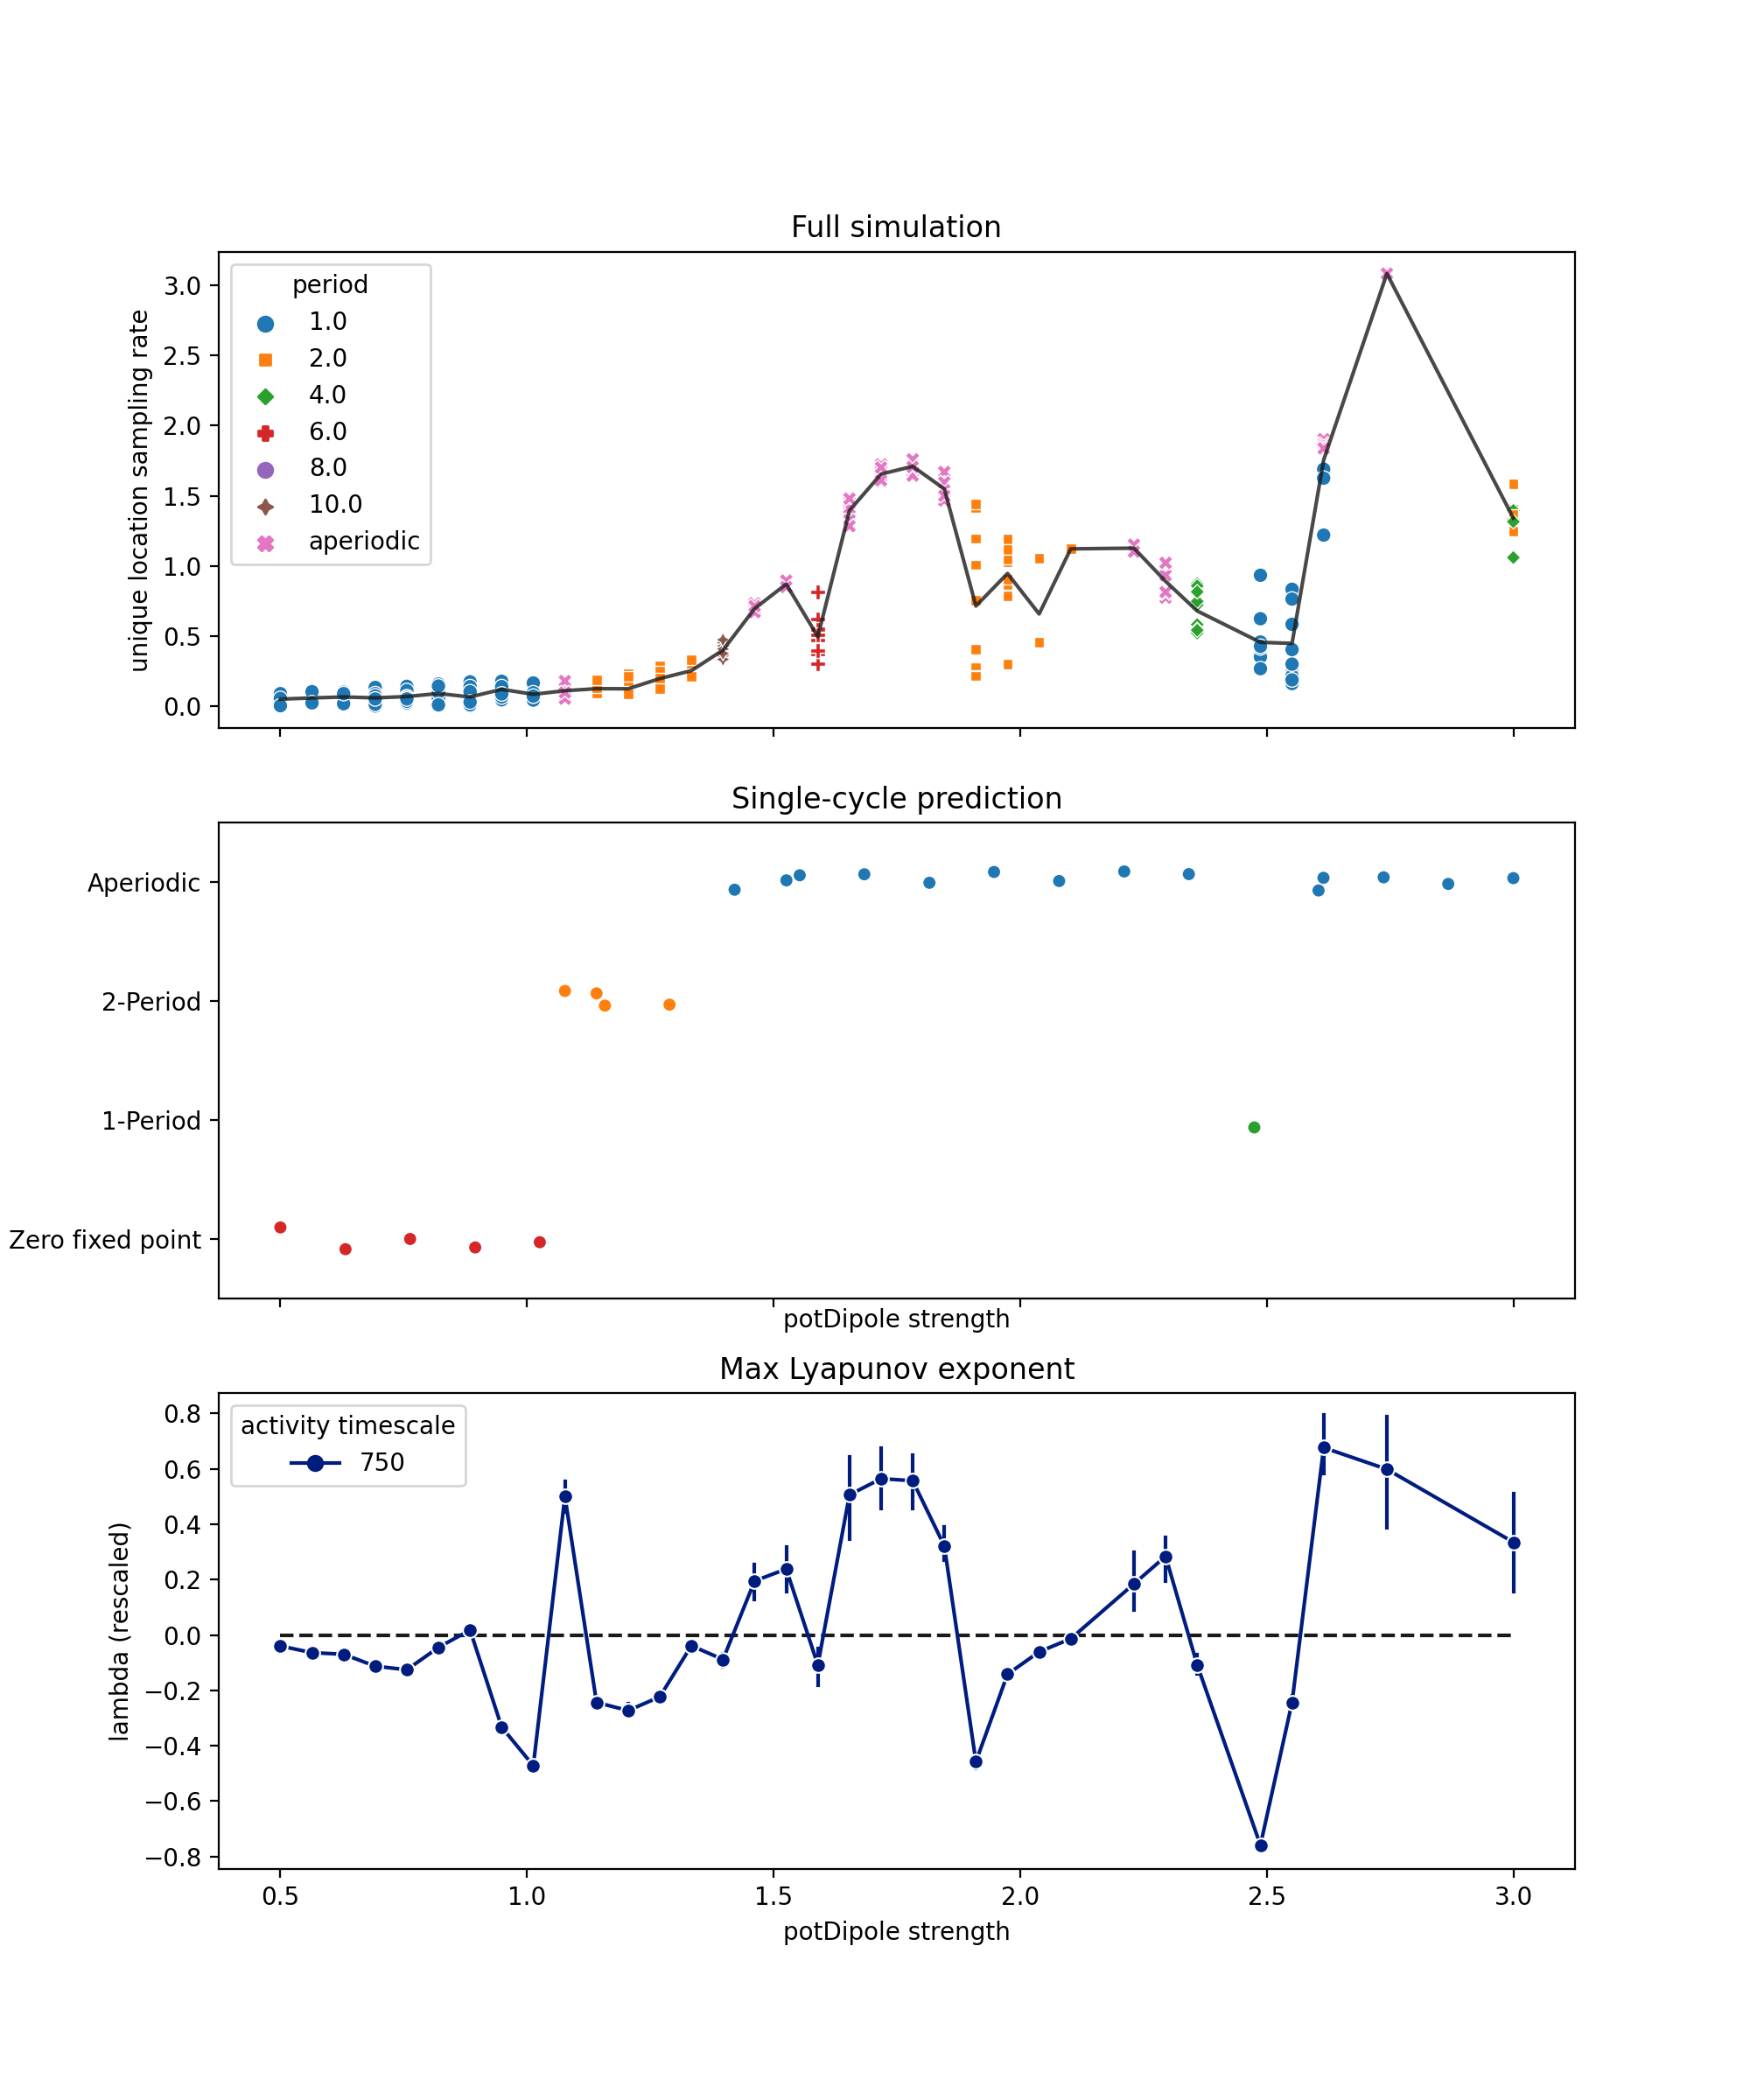

In [14]:
save = True 

predicted_dynamics = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/PredictedDynamics/PredictedDynamics.csv'

df_predicted_dynamics = pd.read_csv(predicted_dynamics)

# Lyapunov exponent data
lyapunov_data = '/home/deepak/Dropbox/LacryModeling/processed_data/IC_sensitivity_analysis/lyapunov_exp_vs_potDipole strength.csv'

df_lyapunov = pd.read_csv(lyapunov_data)

fig,(ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (10,12))
title = 'FullSimVsPredictedDynamics_LyapunovExponent'
sns.lineplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style=" activity time scale", 
             markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', 
             color = 'k', alpha =0.8, legend = False, ax = ax0)

sns.scatterplot(data=df_subset, x= parameter, y= 'unique location sampling rate', style="period", 
                hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'], ax = ax0)

sns.stripplot(data = df_predicted_dynamics, x = parameter, y = 'Predicted dynamics', 
            order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], ax = ax1)

sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (rescaled)', style = 'activity timescale', 
             hue="activity timescale", err_style = 'bars', markers = True, palette = 'dark', ax=ax2)
ax2.hlines(y=0, xmin=min(df_lyapunov[parameter]),xmax=max(df_lyapunov[parameter]), linestyle = '--', color = 'k')

ax0.title.set_text('Full simulation')
ax1.title.set_text('Single-cycle prediction')
ax2.title.set_text('Max Lyapunov exponent')

# plt.title(title)

if (save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

## 3. Unique locations sampled statistics

In [9]:
# Choose the data folder which we want to plot

data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivitySims_2022_11_11'

parameter_values_to_plot = [0.5,  1.21, 1.59, 1.71, 2.74]
# parameter_values_to_plot = [1.2]

In [10]:
# Interpolate time-series data into a common time array
n_times = 1000

# Data frame containing the ensemble data
df_ensemble = pd.DataFrame({})

# Metadata to save
# metadata_list = ['spring constant', 'kappa_hat','potDipole strength']

parameter = 'potDipole strength'
count = 1
# Find all simulation data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files
for root, dirs, files in os.walk(data_folder):
       
    
#     root, subFolderName = os.path.split(dirs)

    for file in files:
            
        if('unique_counts_timeseries' in file):
                
            analysis_file = file.replace('unique_counts_timeseries', 'analysis')
            
            analysis_folder, *rest = os.path.split(root)

            analysis_file_path = os.path.join(analysis_folder,analysis_file)
            
            print(analysis_file_path)
            assert(os.path.exists(analysis_file_path))
            
            # Load the metadata
            df_metadata = pd.read_csv(analysis_file_path)
            
            # activity number
            viscosity = df_metadata['viscosity'][0]
            L = (df_metadata['N particles'][0]-1)*df_metadata['bond length'][0]
            kappa = df_metadata['kappa_hat'][0]*df_metadata['bond length'][0]
            radius = df_metadata['radius'][0]
            D0 = df_metadata['potDipole strength'][0]
            
            activity_number = (viscosity*radius**3*L**2*D0/kappa)

            activity_timescale = df_metadata[' activity time scale'][0]
            sim_complete = df_metadata['simulation completed'][0]

            parameter_value = df_metadata[parameter][0]

            periodic_dynamics = df_metadata['periodic dynamics'][0]
            
        

            if(periodic_dynamics):

                period = int(df_metadata['period'][0])

            else:
                period = 'Aperiodic'


            plot_parameter_flag = np.any(abs(parameter_value - parameter_values_to_plot)<=0.02)
#             plot_parameter_flag = True


            if(sim_complete and plot_parameter_flag):
               
                # Load the time-series data
                df_current = pd.read_csv(os.path.join(root, file))
                time = df_current['Time']
                data = df_current['Unique positions count']

                data_fun = interpolate.interp1d(time, data, kind = 'linear')

                time_vect_sampled = np.linspace(np.min(time), np.max(time), n_times)

                data_sampled = data_fun(time_vect_sampled)

#                 temp_dict = {var : [np.repeat(df_metadata[var], n_times)] for var in metadata_list}

                df_sampled = pd.DataFrame({'Time':time_vect_sampled, 'Initial condition': np.repeat(count, n_times),
                                           'Unique locations visited': data_sampled, 
                                           parameter:np.repeat(np.round(df_metadata[parameter],2), n_times), 
                                           'activity time scale':np.repeat(df_metadata[' activity time scale'], n_times),
                                           'activity number': np.round(activity_number,1),
                                           'period': np.repeat(period, n_times)})


                df_ensemble = df_ensemble.append(df_sampled)
                count +=1 
    

    
        

print(count)



/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_03__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_08__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point/Analysis/SimResults_05__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.487_activityTime_750_simType_point/Analysis/SimResults_08__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.487_activityTime_750_simType_point/Analysis/SimResults_05__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.487_activityTime_750_simType_point/Analysis/SimResults_07__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.487_activityTime_750_simType_point/Analysis/SimResults_00__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.397_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.397_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.397_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.397_activityTime_750_simType_point/Analysis/SimResults_09__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/Analysis/SimResults_00__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/Analysis/SimResults_02__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.167_activityTime_750_simType_point/Analysis/SimResults_02__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.628_activityTime_750_simType_point/Analysis/SimResults_01__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.628_activityTime_750_simType_point/Analysis/SimResults_06__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.628_activityTime_750_simType_point/Analysis/SimResults_04__analysis.csv
/home/deepak/ActiveFilamentsSearch_backup_3/Activity

In [11]:
df_ensemble['Cycle'] = df_ensemble['Time']/df_ensemble['activity time scale']

df_ensemble

,Time,Initial condition,Unique locations visited,potDipole strength,activity time scale,activity number,period,Cycle
0,0.000000,1,1.0,0.50,750,26.9,1,0.000000
0,375.375375,1,1.0,0.50,750,26.9,1,0.500501
0,750.750751,1,1.0,0.50,750,26.9,1,1.001001
0,1126.126126,1,1.0,0.50,750,26.9,1,1.501502
0,1501.501502,1,1.0,0.50,750,26.9,1,2.002002
...,...,...,...,...,...,...,...,...
0,373498.498498,41,1542.0,2.74,750,147.6,Aperiodic,497.997998
0,373873.873874,41,1542.0,2.74,750,147.6,Aperiodic,498.498498
0,374249.249249,41,1542.0,2.74,750,147.6,Aperiodic,498.998999
0,374624.624625,41,1542.0,2.74,750,147.6,Aperiodic,499.499499


In [12]:
print(np.unique(df_ensemble[parameter]))

[0.5  1.21 1.59 1.72 2.74]


In [13]:
# Max no:of unique locations possible
Np = 32
b0 = 2.1
L = (Np-1)*b0
max_unique_locations = int((L)**2)

print('Max possible unique locations: {}'.format(max_unique_locations))

Max possible unique locations: 4238


<IPython.core.display.Javascript object>


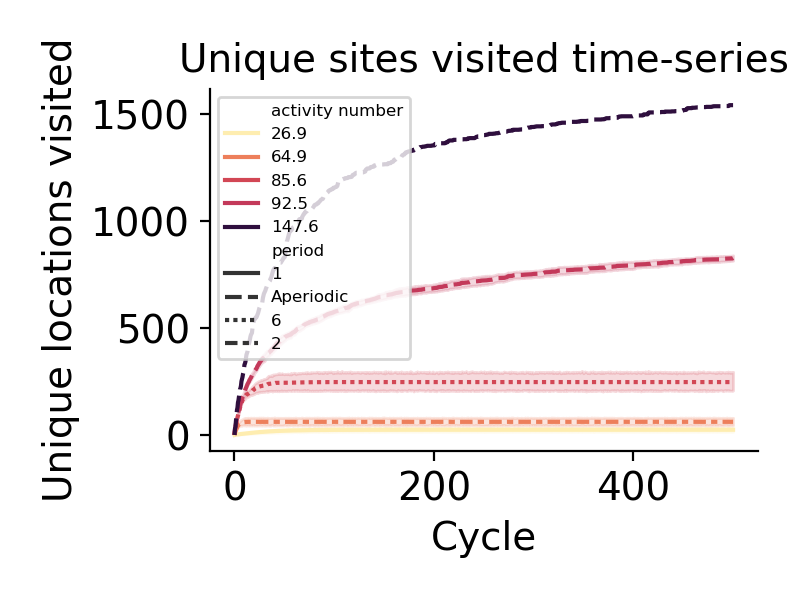

In [14]:
import cmocean
# Set the values for the publication figure parameters
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica') 
# rc('text', usetex='false') 
# rcParams.update({'font.size': 16})
# sns.set(font_scale = 1)
# # plt.style.use('dark_background')
# plt.style.use('default')
parameter = 'activity number'
save = False

title = 'Unique sites visited time-series'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = 'Cycle', 
             y = 'Unique locations visited', hue = parameter, style = 'period', ci = 95, 
             palette = cmocean.cm.matter, legend = 'full')

plt.title(title)
plt.xlabel('Cycle')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

In [15]:
# Rescale the unique locations visited by the max number
df_ensemble['Max locs percent'] = 100*df_ensemble['Unique locations visited']/max_unique_locations

<IPython.core.display.Javascript object>


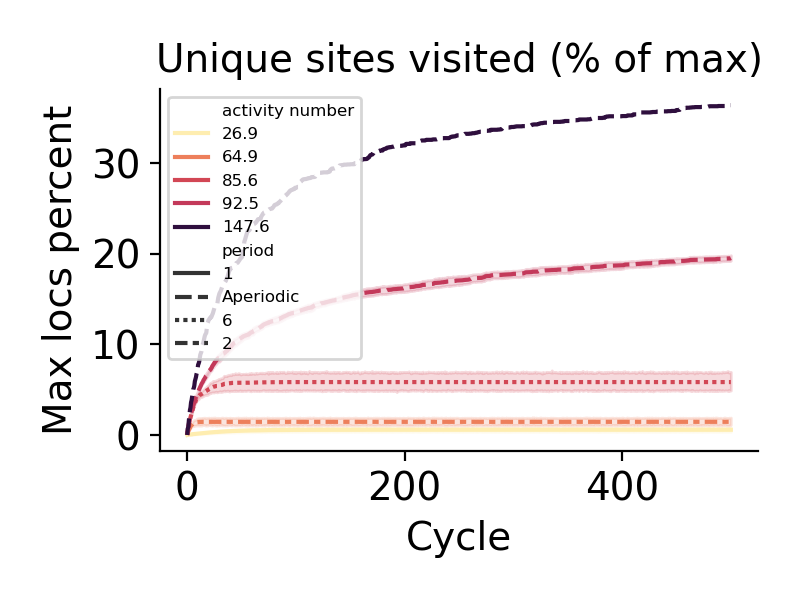

In [55]:
# Plot as percentage of maximum possible locations in the arena

import cmocean
# Set the values for the publication figure parameters
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica') 
# rc('text', usetex='false') 
# rcParams.update({'font.size': 16})
# sns.set(font_scale = 1)
# # plt.style.use('dark_background')
# plt.style.use('default')

save = False

title = 'Unique sites visited (% of max)'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = 'Cycle', 
             y = 'Max locs percent', hue = parameter, style = 'period', ci = 95, 
             palette = cmocean.cm.matter, legend = 'full')

plt.title(title)
plt.xlabel('Cycle')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## Fit the Unique location sampled time-series to Michelis-mentin type curve to extract the intrinsic time-scale for search

In [58]:
import scipy.optimize as optimize

def michelis_mentin(t, tau, N_max):
    
    return t*N_max/(t + tau)



# Use the mean over all the initial conditions from the dataframe

unique_locs_visited_means = df_ensemble.groupby(['activity number', 'Cycle'],as_index=False)['Max locs percent'].mean()



In [59]:
unique_locs_visited_means

,activity number,Cycle,Max locs percent
0,26.9,0.000000,0.023596
1,26.9,0.500501,0.049552
2,26.9,1.001001,0.058990
3,26.9,1.501502,0.063709
4,26.9,2.002002,0.070788
...,...,...,...
4995,147.6,497.997998,36.385087
4996,147.6,498.498498,36.385087
4997,147.6,498.998999,36.385087
4998,147.6,499.499499,36.385087


<IPython.core.display.Javascript object>


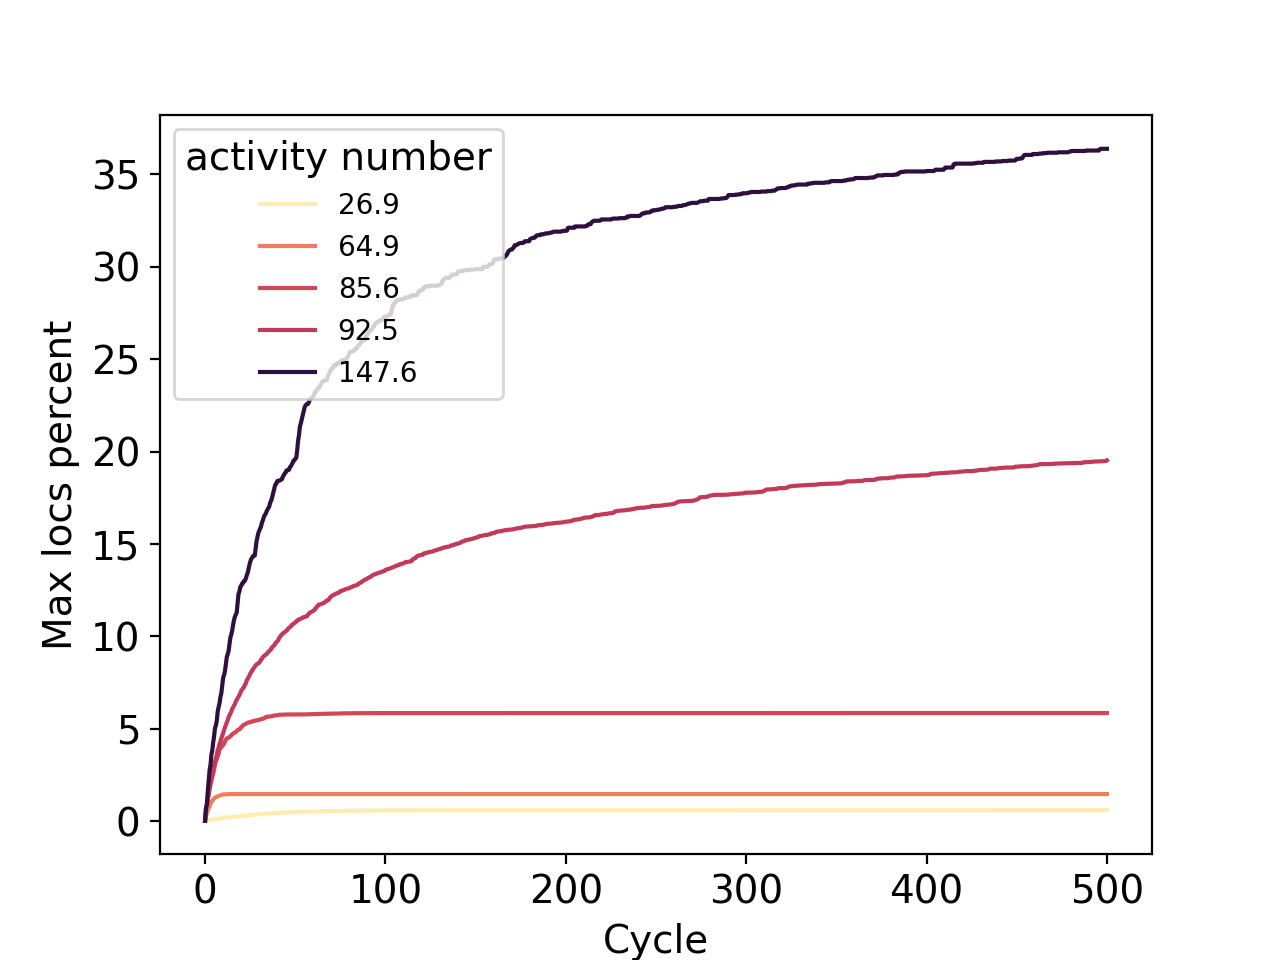

In [61]:
plt.figure()
sns.lineplot(data = unique_locs_visited_means, x = 'Cycle', 
             y = 'Max locs percent', hue = parameter, 
             palette = cmocean.cm.matter, legend = 'full')
plt.show()

In [35]:
for x in np.unique(unique_locs_visited_means['activity number']):
    print(x)

26.9
64.9
85.6
92.5
147.6


<IPython.core.display.Javascript object>


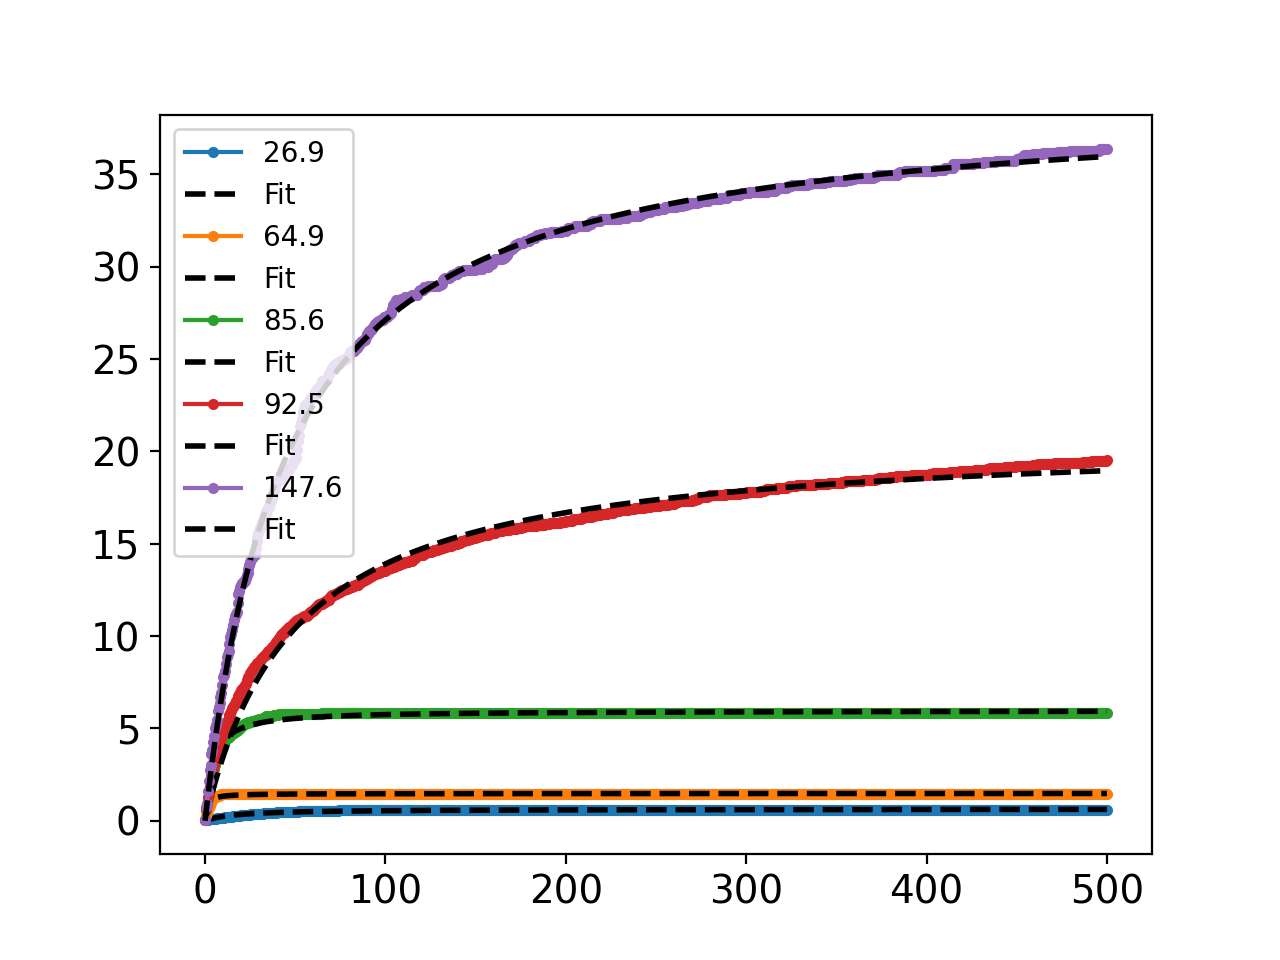

Saturation time (cycles) 16.861434635997984
Fraction of max unique locations (%) 0.6396164170766898
Saturation time (cycles) 1.1548866881935418
Fraction of max unique locations (%) 1.4829358219564983
Saturation time (cycles) 3.885506460767871
Fraction of max unique locations (%) 5.974701998258018
Saturation time (cycles) 49.90106752460413
Fraction of max unique locations (%) 20.850068801704055
Saturation time (cycles) 44.420828951115325
Fraction of max unique locations (%) 39.16572174744431


In [62]:
plt.figure()

for activity_number in np.unique(unique_locs_visited_means['activity number']):
    
    df_chunk = unique_locs_visited_means.loc[unique_locs_visited_means['activity number']== activity_number]


    cycles = np.array(df_chunk['Cycle'])
    unique_locations = np.array(df_chunk['Max locs percent'])

    p_opt, p_conv = optimize.curve_fit(michelis_mentin, cycles, unique_locations, bounds = [(0, 0), (np.inf, np.inf)])
    
    print('Saturation time (cycles)', p_opt[0])
    print('Fraction of max unique locations (%)', p_opt[1])
    data_fit = np.array([michelis_mentin(cycle, p_opt[0], p_opt[1]) for cycle in cycles])


    plt.plot(cycles, unique_locations, marker = '.', label = activity_number)
    plt.plot(cycles, data_fit, linestyle = '--', linewidth = 2, color = 'k', label ='Fit')

plt.legend()
plt.show()

In [46]:
p_opt, p_conv

(array([  44.42082902, 1659.84328806]),
 array([[0.01637831, 0.09958644],
        [0.09958644, 0.82399293]]))

<IPython.core.display.Javascript object>


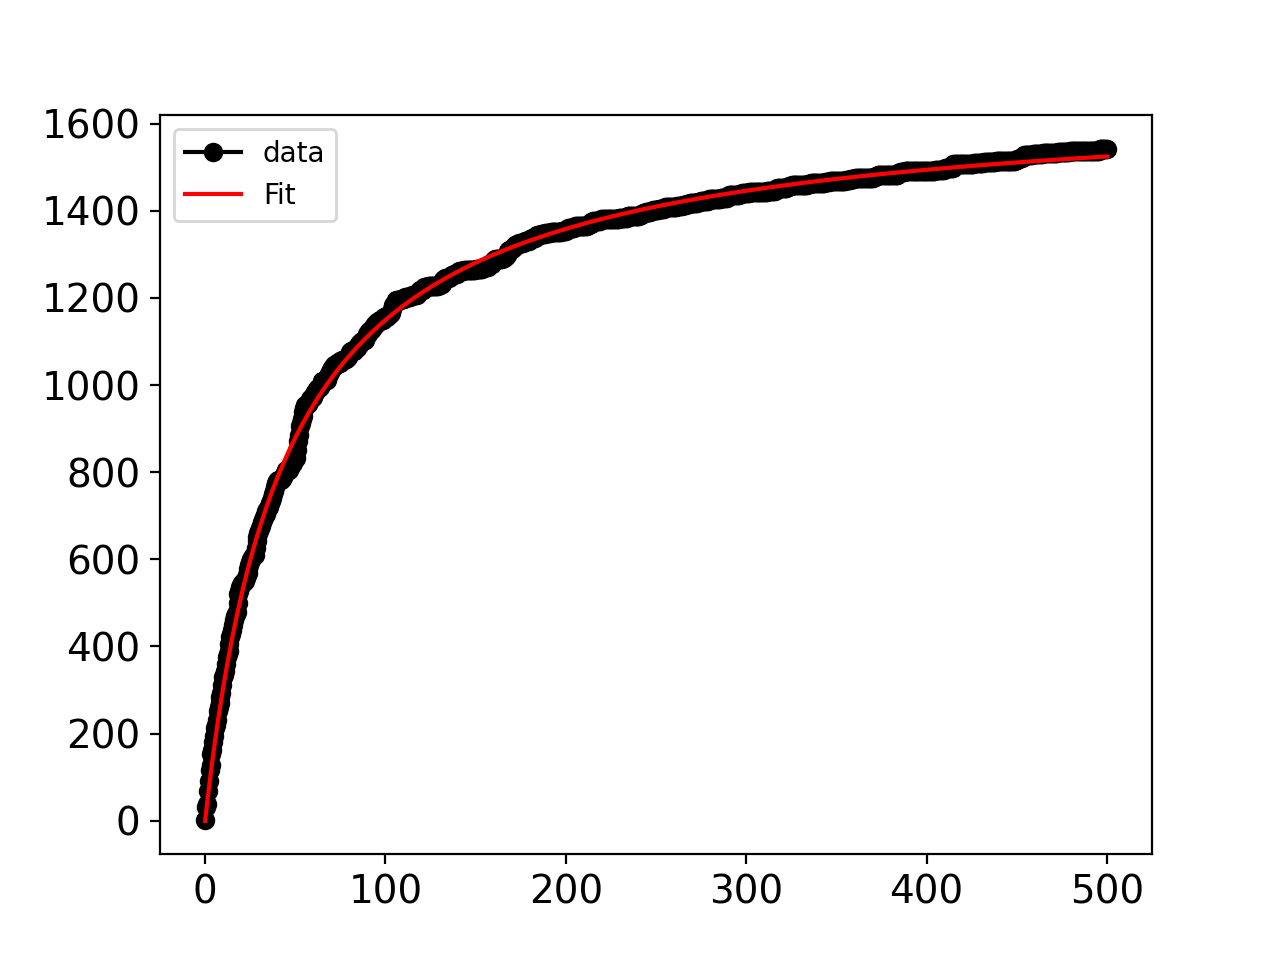

In [47]:
# Plot the data along with the fit

data_fit = np.array([michelis_mentin(cycle, p_opt[0], p_opt[1]) for cycle in cycles])

plt.figure()

plt.plot(cycles, unique_locations, marker = 'o', color = 'k', label = "data")
plt.plot(cycles, data_fit, linestyle = '-', color = 'r', label ='Fit')

plt.legend()
plt.show()

## 4. Convex-hull of Unique Points vs Time 

Above we plotted the No:of unique locations of the filament tip. Now we look at a different but related metric: the convex-hull of the unique locations. This tells us how fast the filament samples the space around it. This also distinguishes between systematic vs stochastic sampling of space.  

,Unnamed: 0,ID,Time,Hits,Position X,Position Y,Position Z
0,0,0,0.0,30,52.727653,38.181207,0.0
1,1,1,20.0,47,50.970085,36.873615,0.0
2,2,2,70.0,64,49.310956,35.518895,0.0
3,3,3,100.0,71,47.775134,33.766284,0.0
4,4,4,120.0,50,45.491678,33.198749,0.0
...,...,...,...,...,...,...,...
848,848,848,362780.0,4,12.990454,-27.146557,0.0
849,849,849,362800.0,1,11.228153,-29.142196,0.0
850,850,850,362970.0,5,-1.561816,-44.721879,0.0
851,851,851,362990.0,2,-2.886873,-46.411694,0.0


In [ ]:
# Calculate the co

## 5. Distribution of First-passage Times vs Parameter

In [17]:
# Load the first passage time data
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23'
parameter = 'potDipole strength'


In [28]:
# Find all simulation data files and create a list
files_list = []

df_fpt = pd.DataFrame({})
 # Walk through the folders and identify the simulation data files
count = 1
for dirs, subdirs, files in os.walk(data_folder, topdown=False):
       
    
    root, subFolderName = os.path.split(dirs)
 
    if('SearchCoverage' in subFolderName):
        
        root, *rest = os.path.split(root) # root is the top-level folder 2 layers up to subfolder
   
        # Get the metadata for this condition
        df_metadata = pd.read_csv(os.path.join(root, 'metadata.csv'))
        
        
        plot_parameter_flag = np.any(abs(parameter_value - parameter_values_to_plot)<=0.05)

        
        for file in files:
            if('unique_positions' in file):
                # Load the unique positions data
                
                
                df_unique_positions = pd.read_csv(os.path.join(dirs,file))
                hits_counter_keys, hits_counter_values = df_unique_positions['ID'], df_unique_positions['Hits']
                
                
                unique_position_times = df_unique_positions['Time']/df_metadata[' activity time scale'][0]
                
                df_fpt = df_fpt.append(pd.DataFrame({'ID':hits_counter_keys, 'counts':hits_counter_values, 'First-passage-cycle':unique_position_times, parameter:np.repeat(df_metadata[parameter][0], len(df_unique_positions),axis =0)}))
                
                count+=1
                
print('Found {} data files'.format(count))

Found 401 data files


In [49]:
df_fpt

,ID,counts,First-passage-cycle,potDipole strength,normalized count
0,0,41,0.000000,0.692308,4.1
1,1,31,0.400000,0.692308,3.1
2,2,35,0.693333,0.692308,3.5
3,3,10,1.426667,0.692308,1.0
4,4,71,1.560000,0.692308,7.1
...,...,...,...,...,...
592,592,2,36.640000,2.871795,0.2
593,593,2,36.666667,2.871795,0.2
594,594,2,36.693333,2.871795,0.2
595,595,3,36.720000,2.871795,0.3


<IPython.core.display.Javascript object>


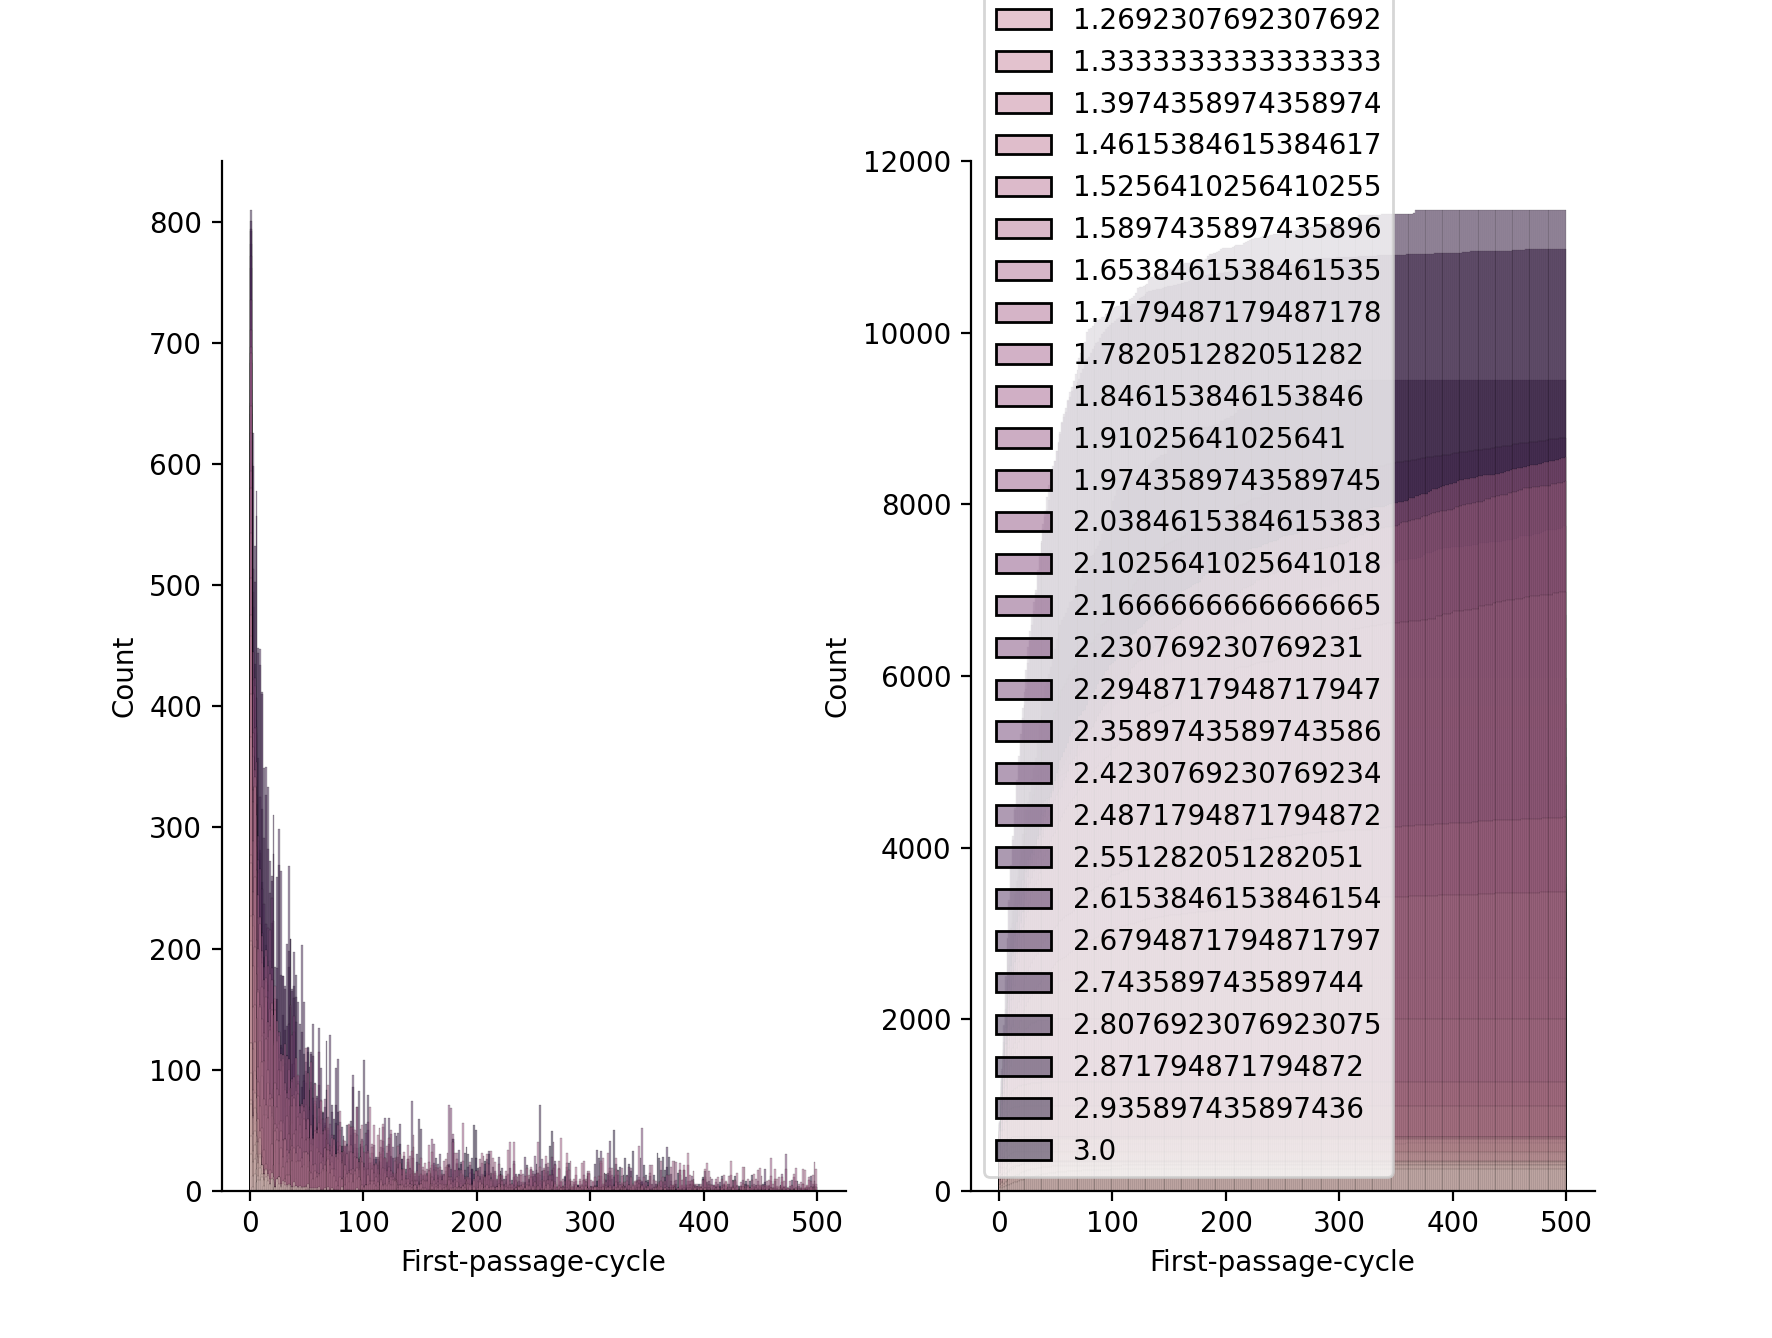

In [32]:
### Plot the first-passage cycle vs different parameters

f, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(7, 5))
sns.despine(f)

sns.histplot(data = df_fpt, x = 'First-passage-cycle', hue = parameter, stat = 'count', ax = ax0, legend = False)
sns.histplot(data = df_fpt, x = 'First-passage-cycle', hue = parameter, stat = 'count', ax = ax1, cumulative=True, legend = 'brief')

plt.show()

In [20]:
parameter

'potDipole strength'